# 提案手法の実験（ラベルが適切か出力）

## マルチサイズ
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

import csv

import numpy as np
import pandas as pd
import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback
# from tf.keras.utils import multi_gpu_model


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 100
encord_size = int(max_size / 2)

NOTEBOOK_NAME = 'wafermap_multisize_train_validation_rotation'
cnn_path = './model/cnn_' + str(max_size) + '_' + NOTEBOOK_NAME + '.h5'

epoch = 30
batch_size = 2048

In [4]:
faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

### データの読み出し

- train

In [5]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/train_rotation/' + '*.npy'))
TRAINS = ['./data/multi_' + str(max_size) + '/train_rotation/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/train_rotation/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

x_train = TRAINS
y_train = new_y

- validaiton

In [6]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/validation_rotation/' + '*.npy'))
VALIDATIONS = ['./data/multi_' + str(max_size) + '/validation_rotation/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/validation_rotation/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

x_validation = VALIDATIONS
y_validation = new_y

In [7]:
# batchを取得する関数
from multiprocessing import Pool
import time

def load_array(file):
    return np.load(file)

def get_batch(batch_size): 
    global x_train, y_train
    SIZE = len(x_train)
    # n_batchs
    n_batchs = SIZE//batch_size + 1
    # for でyield
    i = 0
    start = time.time()
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
        Y_batch = y_train[(i * batch_size):((i + 1) * batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        X_batch_name = x_train[(i * batch_size):((i + 1) * batch_size)]

        # filenameにしたがってバッチのtensorを構築
        with Pool() as p:
            arr = p.map(load_array, X_batch_name)
            
        X_batch = np.array(arr).reshape(len(X_batch_name), max_size, max_size, 3)
#         X_batch = np.array([np.load(file)
#                             for file in X_batch_name]).reshape(len(X_batch_name), max_size, max_size, 3)
        i += 1
        print('elapsed time', time.time()-start)
        yield X_batch, Y_batch

- 学習データとテストデータに分割する．

In [8]:
print('Train x : {}, y : {}'.format(len(x_train), y_train.shape))
print('Validation x: {}, y : {}'.format(len(x_validation), y_validation.shape))

Train x : 283171, y : (283171, 9)
Validation x: 4500, y : (4500, 9)


In [9]:
print("loading X_validation...")
with Pool() as p:
    arr = p.map(load_array, x_validation)

x_validation = np.array(arr).reshape(len(x_validation), max_size, max_size, 3)

loading X_validation...


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [10]:
def create_model():
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
#     with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(8, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(64, activation='relu')(flat)
        dense_2 = layers.Dense(32, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [11]:
# model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# # 3-Fold Crossvalidation
# kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
# # results = cross_val_score(model, x_train, y_train, cv=kfold)
# # # Check 3-fold model's mean accuracy
# # print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [12]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "device:XLA_GPU:0"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:XLA_GPU:0')
Number of devices: 3


In [13]:
epoch=5
batch_size=1024
random.seed(1)

In [25]:
model = create_model()
epoch_train_loss = []
epoch_train_acc = []
epoch_validation_loss = []
epoch_validation_acc = []
for ep in range(epoch):
    print("=" * 50)
    print(ep, "/", epoch)
    step_loss = []
    step_acc = []
    
    # batch_size=1000でHDDからバッチを取得する
    for X_batch, Y_batch in get_batch(batch_size):
        model.train_on_batch(X_batch, Y_batch)
        score = model.evaluate(X_batch, Y_batch)
        print("batch loss:", score[0])
        print("batch accuracy:", score[1])
        step_loss.append(score[0])
        step_acc.append(score[1])
    print("Train loss", np.mean(step_loss))
    print("Train accuracy", np.mean(step_acc))
    score = model.evaluate(x_validation, y_validation)
    print("Validation loss:", score[0])
    print("Validation accuracy:", score[1])
    epoch_train_loss.append(np.mean(step_loss))
    epoch_train_acc.append(np.mean(step_acc))
    epoch_validation_loss.append(score[0])
    epoch_validation_acc.append(score[1])
    
    shuffle_indices = random.sample(list(range(len(x_train))), len(x_train))
    x_train = [x_train[i] for i in shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    model.save(cnn_path)

0 / 5
doing 0 / 277
elapsed time 72.39500617980957
32/32 [==============================] - 0s 4ms/step - loss: 0.0603 - accuracy: 0.9863
batch loss: 0.060267165303230286
batch accuracy: 0.986328125
doing 1 / 277
elapsed time 145.05249500274658
32/32 [==============================] - 0s 4ms/step - loss: 0.0565 - accuracy: 0.9844
batch loss: 0.05654129758477211
batch accuracy: 0.984375
doing 2 / 277
elapsed time 220.9268867969513
32/32 [==============================] - 0s 4ms/step - loss: 0.0519 - accuracy: 0.9863
batch loss: 0.05194913223385811
batch accuracy: 0.986328125
doing 3 / 277
elapsed time 297.1925048828125
32/32 [==============================] - 0s 4ms/step - loss: 0.0623 - accuracy: 0.9863
batch loss: 0.06226062402129173
batch accuracy: 0.986328125
doing 4 / 277
elapsed time 372.2093186378479
32/32 [==============================] - 0s 4ms/step - loss: 0.0551 - accuracy: 0.9854
batch loss: 0.055125292390584946
batch accuracy: 0.9853515625
doing 5 / 277
elapsed time 446.14

32/32 [==============================] - 0s 4ms/step - loss: 0.0431 - accuracy: 0.9873
batch loss: 0.04306091368198395
batch accuracy: 0.9873046875
doing 43 / 277
elapsed time 3280.2623674869537
32/32 [==============================] - 0s 4ms/step - loss: 0.0506 - accuracy: 0.9902
batch loss: 0.05060010030865669
batch accuracy: 0.990234375
doing 44 / 277
elapsed time 3354.723263502121
32/32 [==============================] - 0s 4ms/step - loss: 0.0596 - accuracy: 0.9883
batch loss: 0.05960754677653313
batch accuracy: 0.98828125
doing 45 / 277
elapsed time 3431.0185120105743
32/32 [==============================] - 0s 4ms/step - loss: 0.0440 - accuracy: 0.9951
batch loss: 0.04400277137756348
batch accuracy: 0.9951171875
doing 46 / 277
elapsed time 3504.313545703888
32/32 [==============================] - 0s 4ms/step - loss: 0.0479 - accuracy: 0.9883
batch loss: 0.047905273735523224
batch accuracy: 0.98828125
doing 47 / 277
elapsed time 3580.910957336426
32/32 [=========================

32/32 [==============================] - 0s 4ms/step - loss: 0.0699 - accuracy: 0.9814
batch loss: 0.06992369890213013
batch accuracy: 0.9814453125
doing 127 / 277
elapsed time 9576.001121997833
32/32 [==============================] - 0s 4ms/step - loss: 0.0624 - accuracy: 0.9805
batch loss: 0.062417879700660706
batch accuracy: 0.98046875
doing 128 / 277
elapsed time 9653.946919679642
32/32 [==============================] - 0s 4ms/step - loss: 0.0815 - accuracy: 0.9727
batch loss: 0.0814911425113678
batch accuracy: 0.97265625
doing 129 / 277
elapsed time 9732.864505052567
32/32 [==============================] - 0s 4ms/step - loss: 0.0518 - accuracy: 0.9854
batch loss: 0.05184021592140198
batch accuracy: 0.9853515625
doing 130 / 277
elapsed time 9812.124623060226
32/32 [==============================] - 0s 4ms/step - loss: 0.0515 - accuracy: 0.9834
batch loss: 0.051512107253074646
batch accuracy: 0.9833984375
doing 131 / 277
elapsed time 9888.780188798904
32/32 [=====================

32/32 [==============================] - 0s 4ms/step - loss: 0.0494 - accuracy: 0.9893
batch loss: 0.04937659204006195
batch accuracy: 0.9892578125
doing 169 / 277
elapsed time 12942.663646697998
32/32 [==============================] - 0s 4ms/step - loss: 0.0782 - accuracy: 0.9697
batch loss: 0.07820864021778107
batch accuracy: 0.9697265625
doing 170 / 277
elapsed time 13021.367506742477
32/32 [==============================] - 0s 4ms/step - loss: 0.0554 - accuracy: 0.9873
batch loss: 0.05541949346661568
batch accuracy: 0.9873046875
doing 171 / 277
elapsed time 13100.56882596016
32/32 [==============================] - 0s 4ms/step - loss: 0.0539 - accuracy: 0.9844
batch loss: 0.0538620725274086
batch accuracy: 0.984375
doing 172 / 277
elapsed time 13181.114670753479
32/32 [==============================] - 0s 4ms/step - loss: 0.0485 - accuracy: 0.9854
batch loss: 0.04848765581846237
batch accuracy: 0.9853515625
doing 173 / 277
elapsed time 13261.73238992691
32/32 [====================

32/32 [==============================] - 0s 4ms/step - loss: 0.0581 - accuracy: 0.9805
batch loss: 0.058120422065258026
batch accuracy: 0.98046875
doing 253 / 277
elapsed time 20242.88595533371
32/32 [==============================] - 0s 4ms/step - loss: 0.0504 - accuracy: 0.9805
batch loss: 0.05043572187423706
batch accuracy: 0.98046875
doing 254 / 277
elapsed time 20333.300933361053
32/32 [==============================] - 0s 4ms/step - loss: 0.0404 - accuracy: 0.9902
batch loss: 0.04044023156166077
batch accuracy: 0.990234375
doing 255 / 277
elapsed time 20428.116366386414
32/32 [==============================] - 0s 4ms/step - loss: 0.0495 - accuracy: 0.9854
batch loss: 0.04948481172323227
batch accuracy: 0.9853515625
doing 256 / 277
elapsed time 20523.023687839508
32/32 [==============================] - 0s 4ms/step - loss: 0.0529 - accuracy: 0.9834
batch loss: 0.052944980561733246
batch accuracy: 0.9833984375
doing 257 / 277
elapsed time 20611.653613567352
32/32 [=================

elapsed time 1341.5389590263367
32/32 [==============================] - 0s 4ms/step - loss: 0.0246 - accuracy: 0.9961
batch loss: 0.024637363851070404
batch accuracy: 0.99609375
doing 17 / 277
elapsed time 1417.6531569957733
32/32 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 0.9922
batch loss: 0.027591438964009285
batch accuracy: 0.9921875
doing 18 / 277
elapsed time 1498.213844537735
32/32 [==============================] - 0s 4ms/step - loss: 0.0300 - accuracy: 0.9941
batch loss: 0.03003016486763954
batch accuracy: 0.994140625
doing 19 / 277
elapsed time 1580.6556143760681
32/32 [==============================] - 0s 4ms/step - loss: 0.0338 - accuracy: 0.9941
batch loss: 0.033819492906332016
batch accuracy: 0.994140625
doing 20 / 277
elapsed time 1668.5956451892853
32/32 [==============================] - 0s 4ms/step - loss: 0.0419 - accuracy: 0.9893
batch loss: 0.041878972202539444
batch accuracy: 0.9892578125
doing 21 / 277
elapsed time 1756.30261492729

32/32 [==============================] - 0s 4ms/step - loss: 0.0324 - accuracy: 0.9932
batch loss: 0.03241513669490814
batch accuracy: 0.9931640625
doing 101 / 277
elapsed time 9082.773105621338
32/32 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9912
batch loss: 0.03461828827857971
batch accuracy: 0.9912109375
doing 102 / 277
elapsed time 9181.58546423912
32/32 [==============================] - 0s 4ms/step - loss: 0.0365 - accuracy: 0.9893
batch loss: 0.03652992844581604
batch accuracy: 0.9892578125
doing 103 / 277
elapsed time 9282.238472938538
32/32 [==============================] - 0s 4ms/step - loss: 0.0299 - accuracy: 0.9922
batch loss: 0.0299020204693079
batch accuracy: 0.9921875
doing 104 / 277
elapsed time 9389.444418668747
32/32 [==============================] - 0s 4ms/step - loss: 0.0307 - accuracy: 0.9902
batch loss: 0.03066261112689972
batch accuracy: 0.990234375
doing 105 / 277
elapsed time 9496.697833776474
32/32 [========================

32/32 [==============================] - 0s 4ms/step - loss: 0.0293 - accuracy: 0.9961
batch loss: 0.02934756688773632
batch accuracy: 0.99609375
doing 143 / 277
elapsed time 13597.669142246246
32/32 [==============================] - 0s 4ms/step - loss: 0.0229 - accuracy: 0.9980
batch loss: 0.022870313376188278
batch accuracy: 0.998046875
doing 144 / 277
elapsed time 13711.916210651398
32/32 [==============================] - 0s 4ms/step - loss: 0.0304 - accuracy: 0.9902
batch loss: 0.030372105538845062
batch accuracy: 0.990234375
doing 145 / 277
elapsed time 13827.644178152084
32/32 [==============================] - 0s 4ms/step - loss: 0.0303 - accuracy: 0.9922
batch loss: 0.03026936575770378
batch accuracy: 0.9921875
doing 146 / 277
elapsed time 13942.557368040085
32/32 [==============================] - 0s 4ms/step - loss: 0.0243 - accuracy: 0.9961
batch loss: 0.02425958402454853
batch accuracy: 0.99609375
doing 147 / 277
elapsed time 14063.801942825317
32/32 [====================

32/32 [==============================] - 0s 4ms/step - loss: 0.0260 - accuracy: 0.9951
batch loss: 0.02602582611143589
batch accuracy: 0.9951171875
doing 185 / 277
elapsed time 18074.495407104492
32/32 [==============================] - 0s 4ms/step - loss: 0.0229 - accuracy: 0.9951
batch loss: 0.02290024608373642
batch accuracy: 0.9951171875
doing 186 / 277
elapsed time 18146.221568346024
32/32 [==============================] - 0s 4ms/step - loss: 0.0298 - accuracy: 0.9902
batch loss: 0.029787691310048103
batch accuracy: 0.990234375
doing 187 / 277
elapsed time 18217.976982593536
32/32 [==============================] - 0s 4ms/step - loss: 0.0201 - accuracy: 0.9951
batch loss: 0.020056255161762238
batch accuracy: 0.9951171875
doing 188 / 277
elapsed time 18290.17113661766
32/32 [==============================] - 0s 4ms/step - loss: 0.0240 - accuracy: 0.9922
batch loss: 0.02403109520673752
batch accuracy: 0.9921875
doing 189 / 277
elapsed time 18362.473117113113
32/32 [================

32/32 [==============================] - 0s 4ms/step - loss: 0.0265 - accuracy: 0.9961
batch loss: 0.02650044672191143
batch accuracy: 0.99609375
doing 227 / 277
elapsed time 21075.332659244537
32/32 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9932
batch loss: 0.03489674627780914
batch accuracy: 0.9931640625
doing 228 / 277
elapsed time 21146.171149253845
32/32 [==============================] - 0s 4ms/step - loss: 0.0388 - accuracy: 0.9912
batch loss: 0.03880835324525833
batch accuracy: 0.9912109375
doing 229 / 277
elapsed time 21220.786770105362
32/32 [==============================] - 0s 4ms/step - loss: 0.0268 - accuracy: 0.9922
batch loss: 0.026795219630002975
batch accuracy: 0.9921875
doing 230 / 277
elapsed time 21293.21358513832
32/32 [==============================] - 0s 4ms/step - loss: 0.0400 - accuracy: 0.9844
batch loss: 0.04001263529062271
batch accuracy: 0.984375
doing 231 / 277
elapsed time 21364.406908988953
32/32 [======================

32/32 [==============================] - 0s 4ms/step - loss: 0.0512 - accuracy: 0.9863
batch loss: 0.05122045427560806
batch accuracy: 0.986328125
doing 269 / 277
elapsed time 24131.0287296772
32/32 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 0.9951
batch loss: 0.028972938656806946
batch accuracy: 0.9951171875
doing 270 / 277
elapsed time 24204.583241939545
32/32 [==============================] - 0s 4ms/step - loss: 0.0313 - accuracy: 0.9912
batch loss: 0.03132268786430359
batch accuracy: 0.9912109375
doing 271 / 277
elapsed time 24279.201508522034
32/32 [==============================] - 0s 4ms/step - loss: 0.0409 - accuracy: 0.9893
batch loss: 0.04089405760169029
batch accuracy: 0.9892578125
doing 272 / 277
elapsed time 24355.8254237175
32/32 [==============================] - 0s 4ms/step - loss: 0.1141 - accuracy: 0.9707
batch loss: 0.11412043869495392
batch accuracy: 0.970703125
doing 273 / 277
elapsed time 24430.602450847626
32/32 [==================

32/32 [==============================] - 0s 4ms/step - loss: 0.0365 - accuracy: 0.9912
batch loss: 0.0365164689719677
batch accuracy: 0.9912109375
doing 33 / 277
elapsed time 1526.073157787323
32/32 [==============================] - 0s 4ms/step - loss: 0.0305 - accuracy: 0.9961
batch loss: 0.03053845465183258
batch accuracy: 0.99609375
doing 34 / 277
elapsed time 1570.145943403244
32/32 [==============================] - 0s 4ms/step - loss: 0.0267 - accuracy: 0.9951
batch loss: 0.026747863739728928
batch accuracy: 0.9951171875
doing 35 / 277
elapsed time 1612.5051958560944
32/32 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 0.9961
batch loss: 0.02758619748055935
batch accuracy: 0.99609375
doing 36 / 277
elapsed time 1658.67378616333
32/32 [==============================] - 0s 4ms/step - loss: 0.0263 - accuracy: 0.9941
batch loss: 0.026344679296016693
batch accuracy: 0.994140625
doing 37 / 277
elapsed time 1703.5645678043365
32/32 [==========================

32/32 [==============================] - 0s 4ms/step - loss: 0.0266 - accuracy: 0.9941
batch loss: 0.026603378355503082
batch accuracy: 0.994140625
doing 117 / 277
elapsed time 5574.682954072952
32/32 [==============================] - 0s 4ms/step - loss: 0.0297 - accuracy: 0.9932
batch loss: 0.029700273647904396
batch accuracy: 0.9931640625
doing 118 / 277
elapsed time 5620.602255344391
32/32 [==============================] - 0s 4ms/step - loss: 0.0178 - accuracy: 0.9980
batch loss: 0.017838161438703537
batch accuracy: 0.998046875
doing 119 / 277
elapsed time 5671.604322195053
32/32 [==============================] - 0s 4ms/step - loss: 0.0216 - accuracy: 0.9961
batch loss: 0.021571608260273933
batch accuracy: 0.99609375
doing 120 / 277
elapsed time 5724.001264810562
32/32 [==============================] - 0s 4ms/step - loss: 0.0280 - accuracy: 0.9922
batch loss: 0.028049897402524948
batch accuracy: 0.9921875
doing 121 / 277
elapsed time 5771.870019674301
32/32 [====================

32/32 [==============================] - 0s 4ms/step - loss: 0.0210 - accuracy: 0.9980
batch loss: 0.021013755351305008
batch accuracy: 0.998046875
doing 159 / 277
elapsed time 8294.672966957092
32/32 [==============================] - 0s 4ms/step - loss: 0.0282 - accuracy: 0.9951
batch loss: 0.02816026285290718
batch accuracy: 0.9951171875
doing 160 / 277
elapsed time 8377.607108592987
32/32 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 0.9971
batch loss: 0.01736888289451599
batch accuracy: 0.9970703125
doing 161 / 277
elapsed time 8452.72343993187
32/32 [==============================] - 0s 4ms/step - loss: 0.0219 - accuracy: 0.9971
batch loss: 0.02190319262444973
batch accuracy: 0.9970703125
doing 162 / 277
elapsed time 8523.805908441544
32/32 [==============================] - 0s 4ms/step - loss: 0.0155 - accuracy: 0.9990
batch loss: 0.015468358062207699
batch accuracy: 0.9990234375
doing 163 / 277
elapsed time 8601.942846298218
32/32 [==================

32/32 [==============================] - 0s 4ms/step - loss: 0.0169 - accuracy: 0.9980
batch loss: 0.016858085989952087
batch accuracy: 0.998046875
doing 201 / 277
elapsed time 11842.123139619827
32/32 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 0.9980
batch loss: 0.015178072266280651
batch accuracy: 0.998046875
doing 202 / 277
elapsed time 11930.506727695465
32/32 [==============================] - 0s 4ms/step - loss: 0.0155 - accuracy: 0.9971
batch loss: 0.015512576326727867
batch accuracy: 0.9970703125
doing 203 / 277
elapsed time 12014.25803565979
32/32 [==============================] - 0s 4ms/step - loss: 0.0232 - accuracy: 0.9932
batch loss: 0.02322373352944851
batch accuracy: 0.9931640625
doing 204 / 277
elapsed time 12097.184949159622
32/32 [==============================] - 0s 4ms/step - loss: 0.0153 - accuracy: 0.9990
batch loss: 0.015294281765818596
batch accuracy: 0.9990234375
doing 205 / 277
elapsed time 12183.483257770538
32/32 [============

32/32 [==============================] - 0s 4ms/step - loss: 0.0201 - accuracy: 0.9961
batch loss: 0.02010733261704445
batch accuracy: 0.99609375
doing 243 / 277
elapsed time 15168.545991659164
32/32 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 0.9971
batch loss: 0.017438504844903946
batch accuracy: 0.9970703125
doing 244 / 277
elapsed time 15235.354828357697
32/32 [==============================] - 0s 4ms/step - loss: 0.0193 - accuracy: 0.9961
batch loss: 0.019269902259111404
batch accuracy: 0.99609375
doing 245 / 277
elapsed time 15305.56123828888
32/32 [==============================] - 0s 4ms/step - loss: 0.0163 - accuracy: 0.9961
batch loss: 0.01626676693558693
batch accuracy: 0.99609375
doing 246 / 277
elapsed time 15375.336651563644
32/32 [==============================] - 0s 4ms/step - loss: 0.0138 - accuracy: 1.0000
batch loss: 0.0137917660176754
batch accuracy: 1.0
doing 247 / 277
elapsed time 15444.113916635513
32/32 [============================

elapsed time 464.4984836578369
32/32 [==============================] - 0s 4ms/step - loss: 0.0090 - accuracy: 0.9990
batch loss: 0.008985967375338078
batch accuracy: 0.9990234375
doing 7 / 277
elapsed time 533.1207373142242
32/32 [==============================] - 0s 4ms/step - loss: 0.0086 - accuracy: 1.0000
batch loss: 0.008608001284301281
batch accuracy: 1.0
doing 8 / 277
elapsed time 597.7745649814606
32/32 [==============================] - 0s 4ms/step - loss: 0.0112 - accuracy: 0.9990
batch loss: 0.011188298463821411
batch accuracy: 0.9990234375
doing 9 / 277
elapsed time 664.18594789505
32/32 [==============================] - 0s 4ms/step - loss: 0.0118 - accuracy: 0.9990
batch loss: 0.011751951649785042
batch accuracy: 0.9990234375
doing 10 / 277
elapsed time 732.027101278305
32/32 [==============================] - 0s 4ms/step - loss: 0.0096 - accuracy: 1.0000
batch loss: 0.00962444581091404
batch accuracy: 1.0
doing 11 / 277
elapsed time 801.6426255702972
32/32 [============

elapsed time 3372.6403024196625
32/32 [==============================] - 0s 4ms/step - loss: 0.0127 - accuracy: 0.9990
batch loss: 0.012675242498517036
batch accuracy: 0.9990234375
doing 50 / 277
elapsed time 3438.790610074997
32/32 [==============================] - 0s 4ms/step - loss: 0.0212 - accuracy: 0.9990
batch loss: 0.021203454583883286
batch accuracy: 0.9990234375
doing 51 / 277
elapsed time 3503.7488300800323
32/32 [==============================] - 0s 4ms/step - loss: 0.0095 - accuracy: 1.0000
batch loss: 0.0095345638692379
batch accuracy: 1.0
doing 52 / 277
elapsed time 3569.77304148674
32/32 [==============================] - 0s 4ms/step - loss: 0.0084 - accuracy: 1.0000
batch loss: 0.008360380306839943
batch accuracy: 1.0
doing 53 / 277
elapsed time 3638.2876234054565
32/32 [==============================] - 0s 4ms/step - loss: 0.0107 - accuracy: 0.9990
batch loss: 0.010698171332478523
batch accuracy: 0.9990234375
doing 54 / 277
elapsed time 3705.9322185516357
32/32 [====

elapsed time 6282.270089864731
32/32 [==============================] - 0s 4ms/step - loss: 0.0131 - accuracy: 0.9971
batch loss: 0.013118721544742584
batch accuracy: 0.9970703125
doing 93 / 277
elapsed time 6351.872219800949
32/32 [==============================] - 0s 4ms/step - loss: 0.0102 - accuracy: 0.9990
batch loss: 0.01021004468202591
batch accuracy: 0.9990234375
doing 94 / 277
elapsed time 6423.65255689621
32/32 [==============================] - 0s 4ms/step - loss: 0.0086 - accuracy: 1.0000
batch loss: 0.00859859399497509
batch accuracy: 1.0
doing 95 / 277
elapsed time 6491.949733734131
32/32 [==============================] - 0s 4ms/step - loss: 0.0112 - accuracy: 0.9990
batch loss: 0.011242725886404514
batch accuracy: 0.9990234375
doing 96 / 277
elapsed time 6559.979022264481
32/32 [==============================] - 0s 4ms/step - loss: 0.0082 - accuracy: 0.9990
batch loss: 0.008246229961514473
batch accuracy: 0.9990234375
doing 97 / 277
elapsed time 6628.048766851425
32/32 

32/32 [==============================] - 0s 4ms/step - loss: 0.0186 - accuracy: 0.9971
batch loss: 0.018627610057592392
batch accuracy: 0.9970703125
doing 177 / 277
elapsed time 14553.519644498825
32/32 [==============================] - 0s 4ms/step - loss: 0.0123 - accuracy: 0.9990
batch loss: 0.012345246970653534
batch accuracy: 0.9990234375
doing 178 / 277
elapsed time 14685.591037273407
32/32 [==============================] - 0s 4ms/step - loss: 0.0123 - accuracy: 0.9980
batch loss: 0.012259649112820625
batch accuracy: 0.998046875
doing 179 / 277
elapsed time 14817.067280054092
32/32 [==============================] - 0s 4ms/step - loss: 0.0169 - accuracy: 0.9951
batch loss: 0.016906902194023132
batch accuracy: 0.9951171875
doing 180 / 277
elapsed time 14953.319383382797
32/32 [==============================] - 0s 4ms/step - loss: 0.0172 - accuracy: 0.9961
batch loss: 0.017186127603054047
batch accuracy: 0.99609375
doing 181 / 277
elapsed time 15089.192165136337
32/32 [===========

32/32 [==============================] - 0s 4ms/step - loss: 0.0113 - accuracy: 0.9980
batch loss: 0.011279857717454433
batch accuracy: 0.998046875
doing 261 / 277
elapsed time 26115.23384332657
32/32 [==============================] - 0s 4ms/step - loss: 0.0149 - accuracy: 0.9980
batch loss: 0.014873074367642403
batch accuracy: 0.998046875
doing 262 / 277
elapsed time 26250.519240379333
32/32 [==============================] - 0s 4ms/step - loss: 0.0071 - accuracy: 0.9990
batch loss: 0.007068058475852013
batch accuracy: 0.9990234375
doing 263 / 277
elapsed time 26388.709293603897
32/32 [==============================] - 0s 4ms/step - loss: 0.0076 - accuracy: 0.9990
batch loss: 0.0076276278123259544
batch accuracy: 0.9990234375
doing 264 / 277
elapsed time 26513.86302781105
32/32 [==============================] - 0s 4ms/step - loss: 0.0158 - accuracy: 0.9971
batch loss: 0.01580435037612915
batch accuracy: 0.9970703125
doing 265 / 277
elapsed time 26643.551370620728
32/32 [============

batch loss: 0.007261274382472038
batch accuracy: 0.9990234375
doing 25 / 277
elapsed time 2898.682207584381
32/32 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 1.0000
batch loss: 0.005878414958715439
batch accuracy: 1.0
doing 26 / 277
elapsed time 3002.9452509880066
32/32 [==============================] - 0s 4ms/step - loss: 0.0069 - accuracy: 1.0000
batch loss: 0.006937452591955662
batch accuracy: 1.0
doing 27 / 277
elapsed time 3107.871243238449
32/32 [==============================] - 0s 4ms/step - loss: 0.0092 - accuracy: 0.9990
batch loss: 0.009199121035635471
batch accuracy: 0.9990234375
doing 28 / 277
elapsed time 3212.1587035655975
32/32 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 1.0000
batch loss: 0.0058657703921198845
batch accuracy: 1.0
doing 29 / 277
elapsed time 3316.0562756061554
32/32 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 1.0000
batch loss: 0.00584440166130662
batch accuracy: 

elapsed time 7600.11670422554
32/32 [==============================] - 0s 4ms/step - loss: 0.0057 - accuracy: 1.0000
batch loss: 0.005687675438821316
batch accuracy: 1.0
doing 69 / 277
elapsed time 7705.845079898834
32/32 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 1.0000
batch loss: 0.005993325263261795
batch accuracy: 1.0
doing 70 / 277
elapsed time 7806.892302274704
32/32 [==============================] - 0s 4ms/step - loss: 0.0056 - accuracy: 1.0000
batch loss: 0.005559160839766264
batch accuracy: 1.0
doing 71 / 277
elapsed time 7899.797800064087
32/32 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 1.0000
batch loss: 0.006216584704816341
batch accuracy: 1.0
doing 72 / 277
elapsed time 7999.023217916489
32/32 [==============================] - 0s 4ms/step - loss: 0.0047 - accuracy: 1.0000
batch loss: 0.004742961376905441
batch accuracy: 1.0
doing 73 / 277
elapsed time 8097.440820455551
32/32 [==============================] -

32/32 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 1.0000
batch loss: 0.004889174364507198
batch accuracy: 1.0
doing 155 / 277
elapsed time 16809.32643032074
32/32 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 1.0000
batch loss: 0.0057969773188233376
batch accuracy: 1.0
doing 156 / 277
elapsed time 16924.920494794846
32/32 [==============================] - 0s 4ms/step - loss: 0.0063 - accuracy: 1.0000
batch loss: 0.006291174329817295
batch accuracy: 1.0
doing 157 / 277
elapsed time 17038.245687007904
32/32 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.9990
batch loss: 0.006025982555001974
batch accuracy: 0.9990234375
doing 158 / 277
elapsed time 17150.662581443787
32/32 [==============================] - 0s 4ms/step - loss: 0.0050 - accuracy: 1.0000
batch loss: 0.004958056844770908
batch accuracy: 1.0
doing 159 / 277
elapsed time 17264.29046869278
32/32 [==============================] - 0s 4ms/step

elapsed time 21678.045726776123
32/32 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 1.0000
batch loss: 0.00596885709092021
batch accuracy: 1.0
doing 198 / 277
elapsed time 21781.914036750793
32/32 [==============================] - 0s 4ms/step - loss: 0.0112 - accuracy: 0.9980
batch loss: 0.011222923174500465
batch accuracy: 0.998046875
doing 199 / 277
elapsed time 21884.128120660782
32/32 [==============================] - 0s 4ms/step - loss: 0.0082 - accuracy: 1.0000
batch loss: 0.00821974128484726
batch accuracy: 1.0
doing 200 / 277
elapsed time 21986.204437732697
32/32 [==============================] - 0s 4ms/step - loss: 0.0107 - accuracy: 0.9980
batch loss: 0.010664185509085655
batch accuracy: 0.998046875
doing 201 / 277
elapsed time 22088.068051338196
32/32 [==============================] - 0s 4ms/step - loss: 0.0109 - accuracy: 0.9990
batch loss: 0.010867342352867126
batch accuracy: 0.9990234375
doing 202 / 277
elapsed time 22191.019915819168
32/32

In [26]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|       352|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|            NOTEBOOK_NAME|        93|
|                      Out|       248|
|                     Pool|        72|
|                   TRAINS|   2380496|
|              VALIDATIONS|     38224|
|                  X_batch|       144|
|                  Y_batch|       112|
|                      arr|     36072|
|               batch_size|        28|
|               cnf_matrix|       760|
|                 cnn_path|       112|
|         confusion_matrix|       144|
|                     copy|        88|
|             create_model|       144|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                data_size|        28|
|                 datapat

### テストデータで評価

In [27]:
x_test = joblib.load('./data/multi_' + str(max_size) + '/test/xtest.pickle')
y_test = joblib.load('./data/multi_' + str(max_size) + '/test/ytest.pickle')
y_test = to_categorical(y_test)

In [28]:
score = model.evaluate(x_test, y_test)
# score = model.evaluate(x_validation, y_validation)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
testscore = score[1]
trainscore = epoch_train_acc[-1]
valiscore = epoch_validation_acc[-1]
print("Train accuracy:", trainscore)
print("Validation accuracy:", valiscore)
print("Test accuracy:", testscore)

15/15 [==============================] - 0s 6ms/step - loss: 2.0807 - accuracy: 0.8356
Test loss: 2.080690860748291
Test accuracy: 0.8355555534362793
Train accuracy: 0.999383038131769
Validation accuracy: 0.9237777590751648
Test accuracy: 0.8355555534362793


In [29]:
y_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
np.sum(y_test_max == y_predict, axis=0, dtype='float') / x_test.shape[0]

0.8355555555555556

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 320000)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                20480064  
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

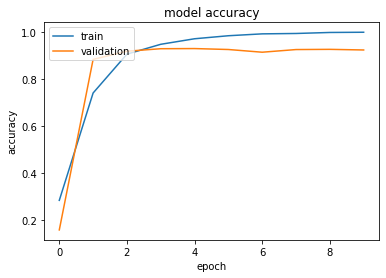

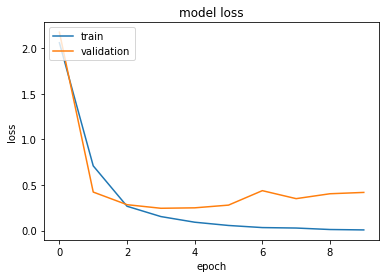

In [31]:
# accuracy plot
fig1 = plt.figure()
plt.plot(epoch_train_acc)
plt.plot(epoch_validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig1.savefig("multisize_accuracy.png")

# loss plot
fig2 = plt.figure()
plt.plot(epoch_train_loss)
plt.plot(epoch_validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig2.savefig("multisize_loss.png")

### 混同行列

In [32]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


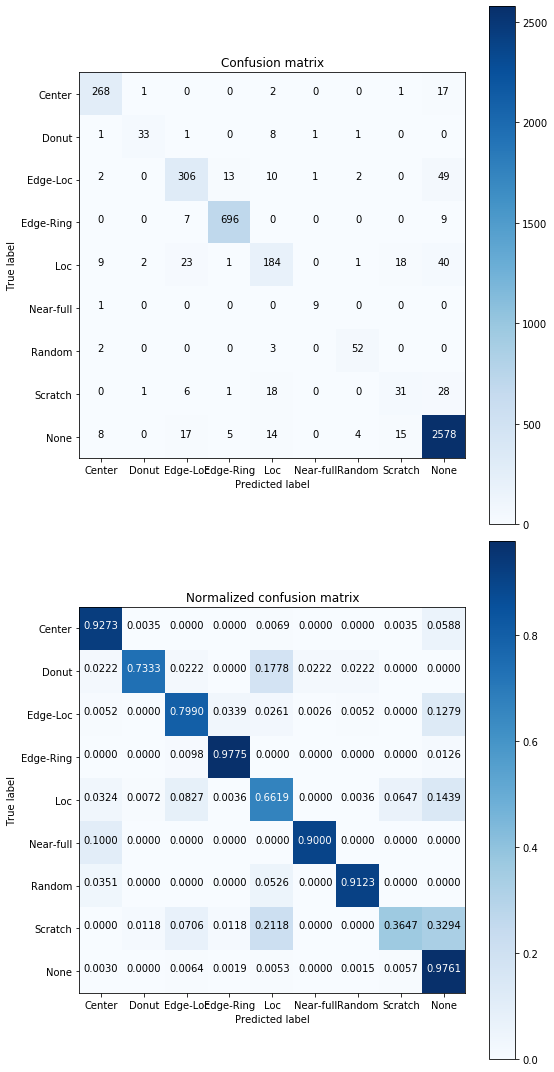

In [33]:
# Compute confusion matrix
y_validation_predict = np.argmax(model.predict(x_validation), axis=1)
y_validation_max = np.argmax(y_validation, axis=1)
cnf_matrix = confusion_matrix(y_validation_max, y_validation_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_valiconfmat.png")

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


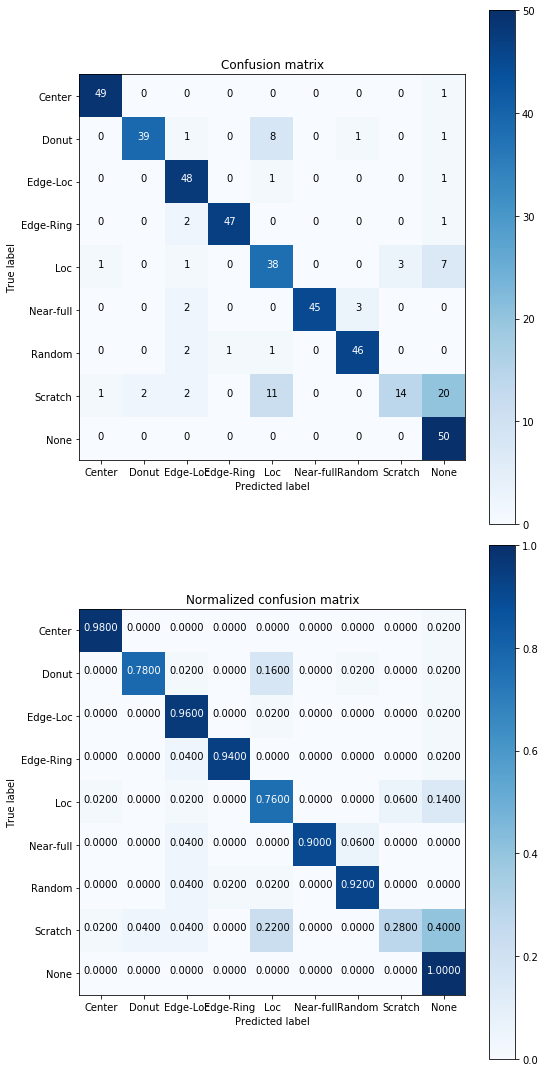

In [34]:
# Compute confusion matrix
y_test_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(y_test_max, y_test_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_testconfmat.png")

In [35]:
import requests

# LINEの設定
path = './lineapi.txt'
with open(path) as f:
    s = f.read()
    line_token = s.rstrip('\n')

# LINEに通知する関数
def line_notify(text):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, headers=headers)#, proxies=proxies)

# LINEに画像を送る関数
def line_notify_img(text, imgpath):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text, "notificationDisabled": True}
    files = {"imageFile": open(imgpath, "rb")}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, files=files, headers=headers)#, proxies=proxies)
    
line_notify("学習が終了しました ")
# line_notify("Shawon: " + str(shawon) + ", rotation_num: " + str(rotation_num) + ", inversion: " + str(inversion) + ", trials: " + str(trials))
line_notify_img("正解率", "multisize_accuracy.png")
line_notify_img("Loss", "multisize_loss.png")
line_notify_img("validation混同行列", "multisize_valiconfmat.png")
line_notify_img("test混同行列", "multisize_testconfmat.png")
line_notify("train:" + str(trainscore) + "\nvali:" + str(valiscore) + "\ntest:" + str(testscore))

ConnectionError: HTTPSConnectionPool(host='notify-api.line.me', port=443): Max retries exceeded with url: /api/notify (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f81487912d0>: Failed to establish a new connection: [Errno 110] Connection timed out'))